# Выпускной проект: телекоммуникации.
# Прогнозирование оттока клиентов.

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг:**

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

**Также доступны такие услуги:**
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Цель работы:** \
Построить модель, которая будет прогнозировать отток клиентов оператора связи. \
Критерии оценки: значение основной метрики AUC-ROC >= 0.85.


## Подготовка данных

**1.1 Загрузка библиотек и глобальных переменных.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import re
import datetime

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoost, CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 310723

In [2]:
!pip install phik
import phik

In [3]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


**1.2 Пользовательские функции.**

In [4]:
def df_info(df):
    print ('\033[1m' + 'Исходные данные'+ '\033[0m')
    print(df.info())
    print(df.shape)
        
    missed_cells = df.isnull().sum().sum()/(df.shape[0]*(df.shape[1]-1))
    missed_rows = sum(df.isnull().sum(axis = 1)>0)/df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))
    
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', df.duplicated().sum())
            
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(df.describe().T)
     
    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(df.describe(include='object').T) 

Дата выгрузки из базы данных:

In [5]:
data_load = '2020-02-01'

**1.3 Загрузим данные.**

Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

In [6]:
contract = pd.read_csv('/datasets/contract_new.csv')

In [7]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [8]:
personal = pd.read_csv('/datasets/personal_new.csv')

In [9]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
internet = pd.read_csv('/datasets/internet_new.csv')

In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
phone = pd.read_csv('/datasets/phone_new.csv')

In [13]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**1.4 Первичный осмотр данных.**

Описательный анализ: информация о договорах.

In [14]:
df_info(contract)

Исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
(7043, 8)

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75



Описание категориальных данных:


,count,unique,top,freq
customerID,7043,7043,6333-YDVLT,1
BeginDate,7043,77,2014-02-01,366
EndDate,7043,67,No,5942
Type,7043,3,Month-to-month,3875
PaperlessBilling,7043,2,Yes,4171
PaymentMethod,7043,4,Electronic check,2365
TotalCharges,7043,6658,,11


Вывод:
- в таблице "Информация о договорах" - 7043 строк и 8 столбцов;
- пропущенных значений нет;
- дубликатов нет;
- необходимо привести названия столбцов к змеиному стилю;
- необходимо поменять тип данных столбцов с датами;
- необходимо поменять тип данных столбца "TotalCharges" на float;
- из 7043 клиентов - 5942 договор не расторгали.


Описательный анализ: персональные данные клиента.

In [15]:
df_info(personal)

Исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
(7043, 5)

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0



Описание категориальных данных:


,count,unique,top,freq
customerID,7043,7043,6333-YDVLT,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933


Вывод:
- в таблице "Персональные данные клиента" 7043 строк и 5 столбцов;
- пропущенных значений нет;
- дубликатов нет;
- необходимо привести названия столбцов к змеиному стилю.

Описательный анализ: информация об интернет-услугах.

In [16]:
df_info(internet)

Исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
(5517, 8)

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Описание количественных данных:


,count,unique,top,freq
customerID,5517,5517,1596-OQSPS,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785



Описание категориальных данных:


,count,unique,top,freq
customerID,5517,5517,1596-OQSPS,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


Вывод:
- в таблице "Информация об интернет-услугах" 5517 строк и 8 столбцов;
- пропущенных значений нет;
- дубликатов нет;
- необходимо привести названия столбцов к змеиному стилю.

Описательный анализ: информация об услугах телефонии.

In [17]:
df_info(phone)

Исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
(6361, 2)

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Описание количественных данных:


,count,unique,top,freq
customerID,6361,6361,6333-YDVLT,1
MultipleLines,6361,2,No,3390



Описание категориальных данных:


,count,unique,top,freq
customerID,6361,6361,6333-YDVLT,1
MultipleLines,6361,2,No,3390


Вывод:
- в таблице "Информация об услугах телефонии" 6361 строка и 2 столбцов;
- пропущенных значений нет;
- дубликатов нет;
- необходимо привести названия столбцов к змеиному стилю.

**План работы:**
1. **Объединить таблицы:**
- во всех таблицах присутствует столбец (ключ) - customerID, по нему будем производить объединение таблиц.
2. **Предобработка данных:**
- привести названия столбцов к змеиному стилю;
- обработать пропущенные значения;
- поиск аномалий;
- проверить типы данных;
- целевой признак - столбец "EndDate", No и дату расторжения договора необходимо заменить на 0 и 1 - создать новый столбец;
- сгенерировать новый признак - срок действия договора. Для действующих договоров используем дату выгрузки из базы данных - "2020-02-01";
- удалить лишние признаки, чтобы не было утечки данных;
- исследовательский (графический) анализ;
- проверить на мультиколлинеарность.
3. **Подготовить данные к обучению:**
- разделить данные на выборки (обучающая - 75%, тестовая - 25%);
- категориальные признаки закодировать техникой OHE;
- масштабирование данных.
4. **Обучение моделей:**
- Логистическая регрессия;
- Случайный лес;
- LGBMClassifier;
- сделать кросс-валидацию;
- сравнить показатели метрик AUC-ROC и Accuracy;
- выбрать лучшую модель.
5. **Проверить лучшую модель на тестовой выборке.**
6. **Написать отчет.**

**1.5 Объединим таблицы по ключу customerID.**

In [18]:
df_full = contract.merge(personal, on='customerID', how='outer') 

In [19]:
df_full = df_full.merge(internet, on='customerID', how='outer') 

In [20]:
df_full = df_full.merge(phone, on='customerID', how='outer') 

In [21]:
df_full.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Описательный анализ: общей таблицы.

In [22]:
df_info(df_full)

Исходные данные
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00



Описание категориальных данных:


,count,unique,top,freq
customerID,7043,7043,6333-YDVLT,1
BeginDate,7043,77,2014-02-01,366
EndDate,7043,67,No,5942
Type,7043,3,Month-to-month,3875
PaperlessBilling,7043,2,Yes,4171
PaymentMethod,7043,4,Electronic check,2365
TotalCharges,7043,6658,,11
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933


## Предобработка данных

**2.1 Приведем названия столбцов к змеиному стилю.**

In [23]:
df_full.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df_full.columns]

In [24]:
df_full.columns

Index(['customer_i_d', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [25]:
df_full.rename(columns={'customer_i_d': 'customer_id', 'streaming_t_v': 'streaming_tv'}, inplace=True)

In [26]:
df_full.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

**2.2 Обработка пропущенных значений.**

In [27]:
df_full.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Образовались пропуски в стобцах с дополнительными услугами, можем предположить:
- если значение пропущено, то у клиента нет доп. интернет услуг и нет возможности вести параллельные линии во время звонка.\
Пропуски заменим на 'No'.

In [28]:
df_full = df_full.fillna('No')

In [29]:
print('Количество пропусков:', df_full.isnull().sum().sum())

Количество пропусков: 0


**2.3 Добавим столбец 'target' с целевым признаком.**

In [30]:
df_full['target'] = (df_full['end_date'] != 'No').astype(int)

In [31]:
df_full['target'].unique()

array([0, 1])

**2.4 Замена типов данных.**

В столбце 'end_date' значения 'No' заменим на дату выгрузки data_load = '2020-02-01'.

In [32]:
df_full.loc[df_full['end_date'] == 'No', 'end_date'] = data_load

In [33]:
df_full['end_date'].unique()

array(['2020-02-01', '2017-05-01', '2016-03-01', '2018-09-01',
       '2018-11-01', '2018-12-01', '2019-08-01', '2018-07-01',
       '2017-09-01', '2015-09-01', '2016-07-01', '2016-06-01',
       '2018-03-01', '2019-02-01', '2018-06-01', '2019-06-01',
       '2020-01-01', '2019-11-01', '2016-09-01', '2015-06-01',
       '2016-12-01', '2019-05-01', '2019-04-01', '2017-06-01',
       '2017-08-01', '2018-04-01', '2018-08-01', '2018-02-01',
       '2019-07-01', '2015-12-01', '2014-06-01', '2018-10-01',
       '2019-01-01', '2017-07-01', '2017-12-01', '2018-05-01',
       '2015-11-01', '2019-10-01', '2019-03-01', '2016-02-01',
       '2016-10-01', '2018-01-01', '2017-11-01', '2015-10-01',
       '2019-12-01', '2015-07-01', '2017-04-01', '2015-02-01',
       '2017-03-01', '2016-05-01', '2016-11-01', '2015-08-01',
       '2019-09-01', '2017-10-01', '2017-02-01', '2016-08-01',
       '2016-04-01', '2015-05-01', '2014-09-01', '2014-10-01',
       '2017-01-01', '2015-03-01', '2015-01-01', '2016-

В столбцах 'begin_date' и 'end_date' изменим тип данных на datetime.

In [34]:
df_full['begin_date'] = pd.to_datetime(df_full['begin_date'], format="%Y-%m-%d")

df_full['end_date'] = pd.to_datetime(df_full['end_date'], format="%Y-%m-%d")

При попытке изменить тип данных на float в столбце 'total_charges' - обнаружено, что в 11 строках не заполнены значения.\
Поменяем тип данных и заменим пропуски на NaN.

In [35]:
df_full['total_charges'] = pd.to_numeric(df_full['total_charges'], errors='coerce')

In [36]:
print('Количество пропусков:', df_full['total_charges'].isnull().sum())

Количество пропусков: 11


Посмотрим на строки с пропущенными значениями:

In [37]:
display(df_full[df_full.isna().any(axis=1)])

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,...,Yes,No,No,No,No,No,No,No,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


У всех клиентов дата заключения договора соответствует дате выгрузки из базы данных, соответственно еще нет общего количества затрат на услуги, но уже выставлена сумма ежемесячного платежа, ей и заполним пропущенные значения.

In [38]:
df_full['total_charges'] = df_full['total_charges']. fillna(df_full['monthly_charges'])

In [39]:
print('Количество пропусков:', df_full.isnull().sum().sum())

df_full.iloc[[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]]

Количество пропусков: 0


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,25.75,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,56.05,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,19.85,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,25.35,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,20.00,Female,0,...,Yes,No,No,No,No,No,No,No,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,19.70,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,73.35,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


Проверим типы данных:

In [40]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

**2.5 Сгенерируем новый признак - срок действия договора.**

Для действующих договоров будем считать срок действия до текущей даты (даты выгрузки из базы данных).

In [41]:
df_full['contract_period'] = (df_full['end_date'] - df_full['begin_date']).dt.days

In [42]:
df_full.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,contract_period
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


**2.6 Удалим лишние признаки, чтобы не было утечки в данных.**

In [43]:
df_full = df_full.drop(columns=['begin_date', 'end_date'], axis=1)

In [44]:
df_full.columns

Index(['customer_id', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'gender', 'senior_citizen',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines', 'target', 'contract_period'],
      dtype='object')

**2.7 Исследовательский (графический) анализ данных. Поиск аномалий.**

Посмотрим типы оплаты для клиентов, которые ушли и остались:

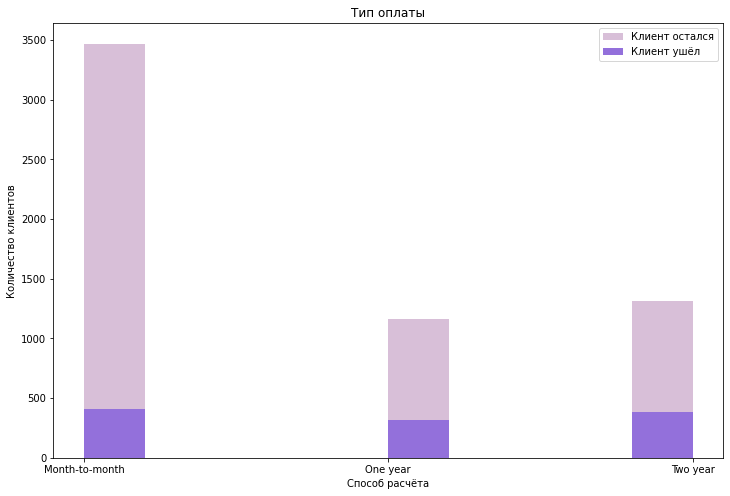

In [45]:
plt.figure(figsize=[12,8])

plt.hist(df_full.loc[df_full['target'] == 0, 'type'], label='Клиент остался', color='thistle')
plt.hist(df_full.loc[df_full['target'] == 1, 'type'], label='Клиент ушёл', color='mediumpurple')

plt.xlabel('Способ расчёта')
plt.ylabel('Количество клиентов')

plt.legend(loc='upper right')
plt.title('Тип оплаты')
plt.show()

- среди клиентов, которые остались, чаще всего использовалась 'ежемесячная оплата';
- для клиентов, которые ушли, тип оплаты распределён примерно одинаково.

Посмотрим ежемесячные платежи для клиентов, которые ушли и остались:

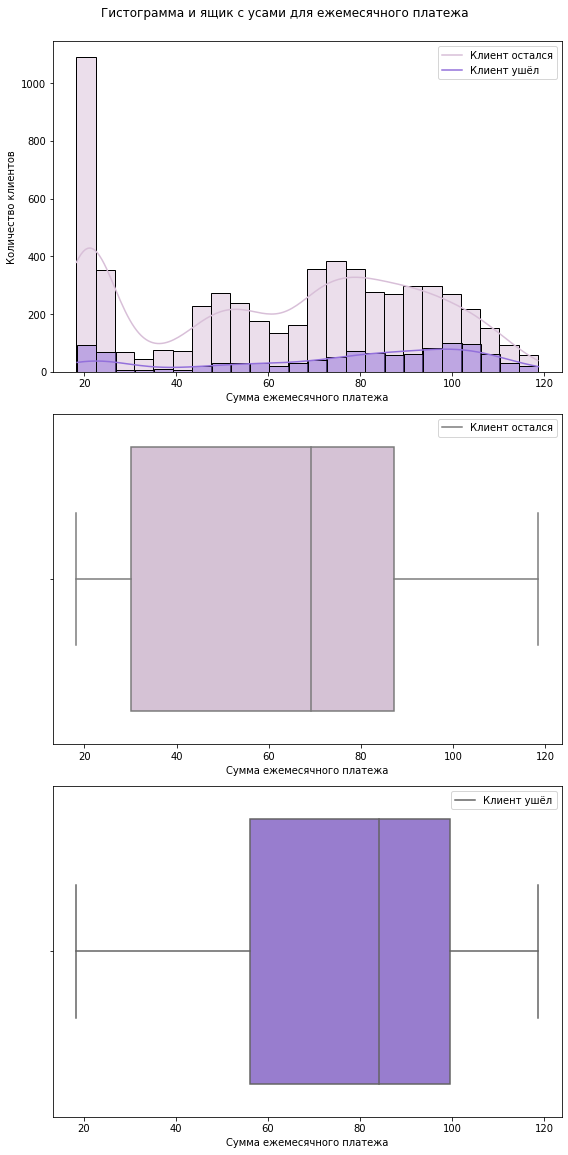

In [46]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1, figsize=[8,16])

sns.histplot(df_full.loc[df_full['target'] == 0, 'monthly_charges'], kde=True, bins=24,  color='thistle', ax=ax1)  
sns.histplot(df_full.loc[df_full['target'] == 1, 'monthly_charges'], kde=True, bins=24,  color='mediumpurple', ax=ax1) 

sns.boxplot(df_full.loc[df_full['target'] == 0, 'monthly_charges'], color='thistle', ax=ax2)
sns.boxplot(df_full.loc[df_full['target'] == 1, 'monthly_charges'], color='mediumpurple', ax=ax3)

ax1.legend(['Клиент остался', 'Клиент ушёл'])
ax1.set_xlabel('Сумма ежемесячного платежа')
ax1.set_ylabel('Количество клиентов')
ax2.set_xlabel('Сумма ежемесячного платежа')
ax2.legend(['Клиент остался'])
ax3.set_xlabel('Сумма ежемесячного платежа')
ax3.legend(['Клиент ушёл'])
plt.suptitle('Гистограмма и ящик с усами для ежемесячного платежа', x=0.5, y=1)

plt.tight_layout()
plt.show()

- наблюдаем большой пик в районе значения суммы платежа = 20, для клиентов которые остались, скорее всего причина - в отсутствии дополнительных услуг;
- количество ушедших клиентов возрастает с увеличением суммы ежемесячного платежа;
- выбросов нет.

Посмотрим общие платежи для клиентов, которые ушли и остались:

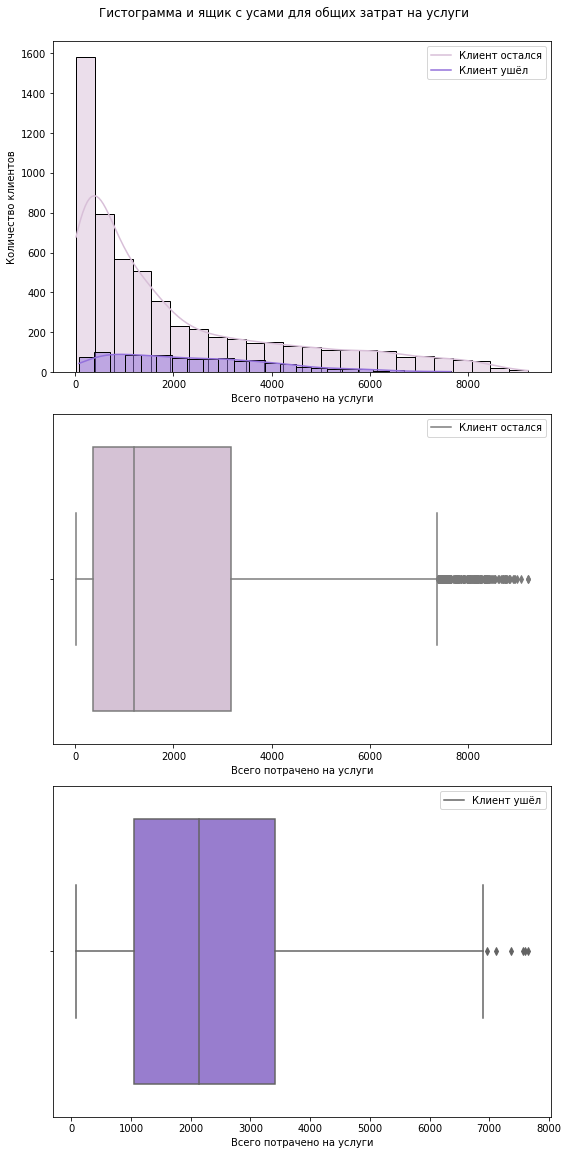

In [47]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1, figsize=[8,16])

sns.histplot(df_full.loc[df_full['target'] == 0, 'total_charges'], kde=True, bins=24,  color='thistle', ax=ax1)  
sns.histplot(df_full.loc[df_full['target'] == 1, 'total_charges'], kde=True, bins=24,  color='mediumpurple', ax=ax1) 

sns.boxplot(df_full.loc[df_full['target'] == 0, 'total_charges'], color='thistle', ax=ax2)
sns.boxplot(df_full.loc[df_full['target'] == 1, 'total_charges'], color='mediumpurple', ax=ax3)

ax1.legend(['Клиент остался', 'Клиент ушёл'])
ax1.set_xlabel('Всего потрачено на услуги')
ax1.set_ylabel('Количество клиентов')
ax2.set_xlabel('Всего потрачено на услуги')
ax2.legend(['Клиент остался'])
ax3.set_xlabel('Всего потрачено на услуги')
ax3.legend(['Клиент ушёл'])
plt.suptitle('Гистограмма и ящик с усами для общих затрат на услуги', x=0.5, y=1)


plt.tight_layout()
plt.show()

- данные распределены не нормально, пик в начале и длинный хвост вправо;
- есть выбросы, необходимо проверить.

In [48]:
abnormal_values = df_full.query('total_charges > 7000')
print(abnormal_values.groupby('type')['total_charges'].count())
display(abnormal_values.head())

type
Month-to-month     14
One year           65
Two year          204
Name: total_charges, dtype: int64


,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,contract_period
17,9959-WOFKT,Two year,No,Bank transfer (automatic),106.70,8257.51,Male,0,No,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Yes,0,2163
57,5067-XJQFU,One year,Yes,Electronic check,108.45,7730.32,Male,1,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes,0,2010
59,5954-BDFSG,Two year,Yes,Credit card (automatic),107.50,7740.00,Female,0,No,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0,2191
72,1891-QRQSA,Two year,Yes,Bank transfer (automatic),111.60,7142.40,Male,1,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes,0,1949
106,6728-DKUCO,One year,Yes,Electronic check,104.15,7498.80,Female,0,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,Yes,Yes,0,2191


- большинство клиентов с общей суммой платежей более 7000 заключили контракт на 2 года;
- исходя из столбца со сроком действия договора, срок составляет 5 лет и выше, отсюда и получаем большие платежные суммы за период.

Посмотрим способы оплаты для клиентов, которые ушли и остались:

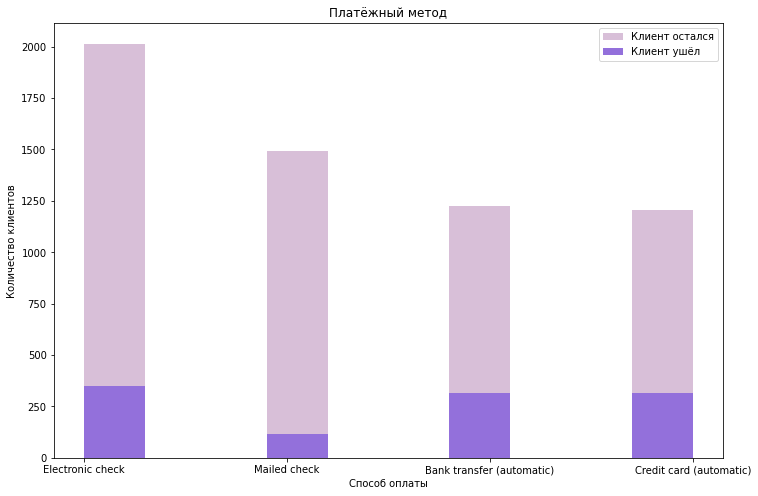

In [49]:
plt.figure(figsize=[12,8])

plt.hist(df_full.loc[df_full['target'] == 0, 'payment_method'], label='Клиент остался', color='thistle')
plt.hist(df_full.loc[df_full['target'] == 1, 'payment_method'], label='Клиент ушёл', color='mediumpurple')

plt.xlabel('Способ оплаты')
plt.ylabel('Количество клиентов')

plt.legend(loc='upper right')
plt.title('Платёжный метод')
plt.show()

- самый популярный способ оплаты - электронный перевод для клиентов, которые остались;
- для клиентов, которые ушли - значения распределены примерно одинаково, кроме - почтового перевода (он самый не популярный способ оплаты).

Посмотрим пол клиентов, которые ушли и остались:

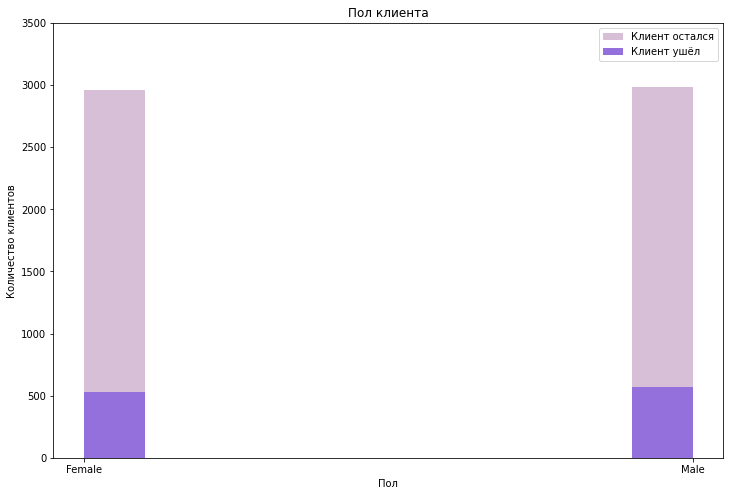

In [50]:
plt.figure(figsize=[12,8])

plt.hist(df_full.loc[df_full['target'] == 0, 'gender'], label='Клиент остался', color='thistle')
plt.hist(df_full.loc[df_full['target'] == 1, 'gender'], label='Клиент ушёл', color='mediumpurple')

plt.ylim([0, 3500])

plt.xlabel('Пол')
plt.ylabel('Количество клиентов')

plt.legend(loc='upper right')
plt.title('Пол клиента')
plt.show()

- женщин незначительно меньше для всех клиентов.

Посмотрим на наличие пенсионного статуса по возрасту для клиентов, которые ушли и остались:

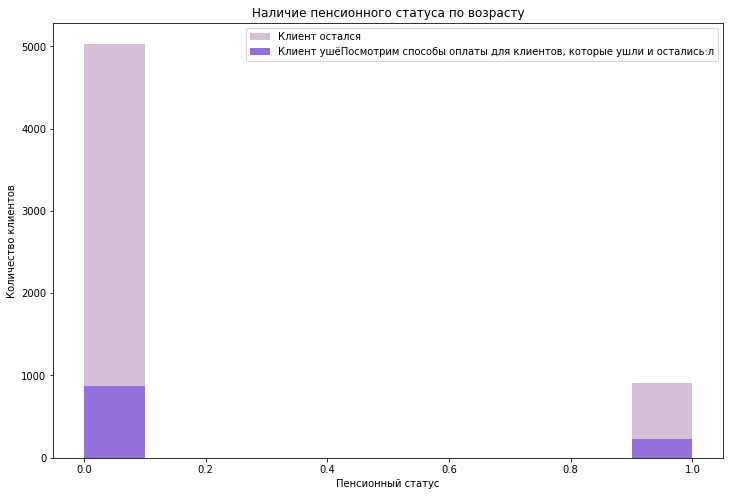

In [51]:
plt.figure(figsize=[12,8])

plt.hist(df_full.loc[df_full['target'] == 0, 'senior_citizen'], label='Клиент остался', color='thistle')
plt.hist(df_full.loc[df_full['target'] == 1, 'senior_citizen'], label='Клиент ушёПосмотрим способы оплаты для клиентов, которые ушли и остались:л', color='mediumpurple')

plt.xlabel('Пенсионный статус')
plt.ylabel('Количество клиентов')

plt.legend(loc='upper right')
plt.title('Наличие пенсионного статуса по возрасту')
plt.show()

- среди клиентов, которые ушли - доля пенсионеров выше.

Посмотрим на семейное положение для клиентов, которые ушли и остались:

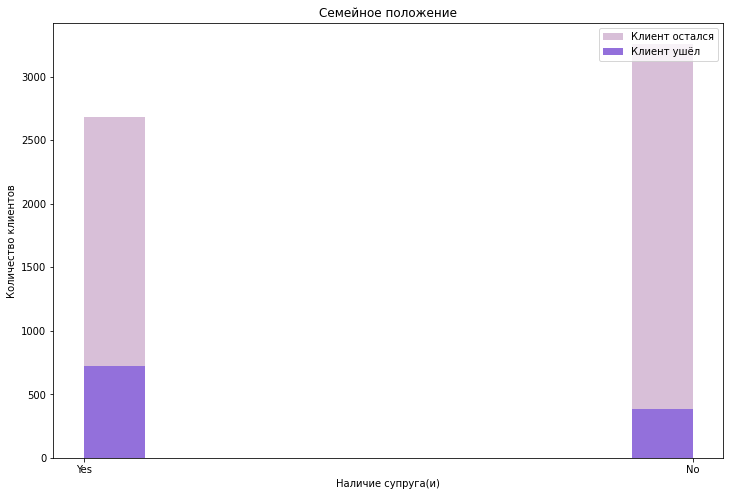

In [52]:
plt.figure(figsize=[12,8])

plt.hist(df_full.loc[df_full['target'] == 0, 'partner'], label='Клиент остался', color='thistle')
plt.hist(df_full.loc[df_full['target'] == 1, 'partner'], label='Клиент ушёл', color='mediumpurple')

plt.xlabel('Наличие супруга(и)')
plt.ylabel('Количество клиентов')

plt.legend(loc='upper right')
plt.title('Семейное положение')
plt.show()

- осталось больше клиентов, которые не заключали брак;
- ушло больше клиентов, состоящих в браке.

Посмотрим на наличие иждевенцев для клиентов, которые ушли и остались:

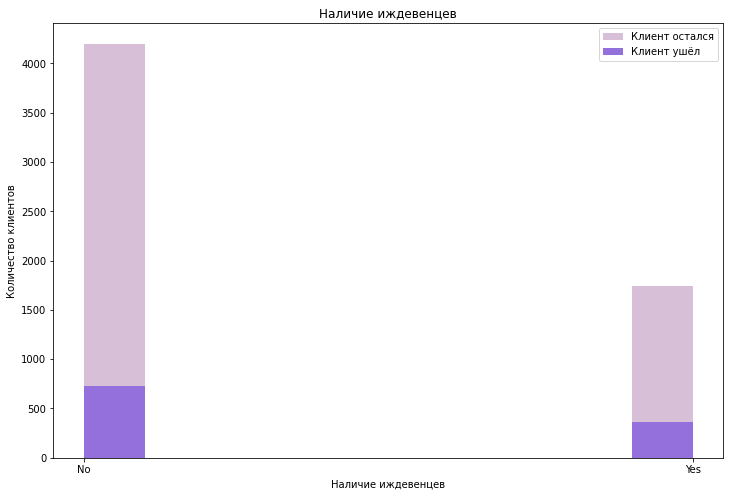

In [53]:
plt.figure(figsize=[12,8])

plt.hist(df_full.loc[df_full['target'] == 0, 'dependents'], label='Клиент остался', color='thistle')
plt.hist(df_full.loc[df_full['target'] == 1, 'dependents'], label='Клиент ушёл', color='mediumpurple')

plt.xlabel('Наличие иждевенцев')
plt.ylabel('Количество клиентов')

plt.legend(loc='upper right')
plt.title('Наличие иждевенцев')
plt.show()

- визуально доля клиентов, у которых есть иждевенец, одинакова и для оставшихся и для ушедших клиентов.

Посмотрим на срок действия договора для клиентов, которые ушли и остались:

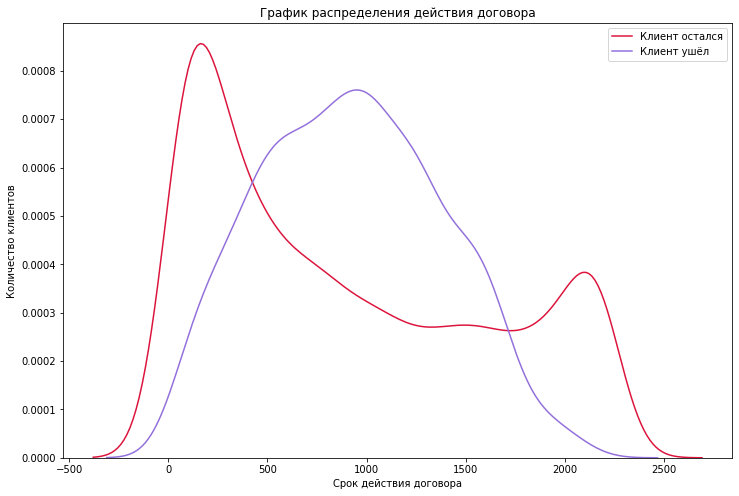

In [54]:
plt.figure(figsize=[12,8])

sns.kdeplot(df_full.loc[df_full['target'] == 0, 'contract_period'], label='Клиент остался', color='crimson')
sns.kdeplot(df_full.loc[df_full['target'] == 1, 'contract_period'], label='Клиент ушёл', color='mediumpurple')

plt.xlabel('Срок действия договора')
plt.ylabel('Количество клиентов')

plt.legend(loc='upper right')
plt.title('График распределения действия договора')
plt.show()

- для оставшихся клиентов видим 2 пика, короткий (возможно новые клиенты) и длинный срок действия договора;
- для ушедших клиентов - нормальное распределение;
- в среднем клиенты пользуются услугами около 3 лет, после чего постепенно начинают отказываться;

Посмотрим на дополнительные услуги для клиентов, которые ушли и остались:

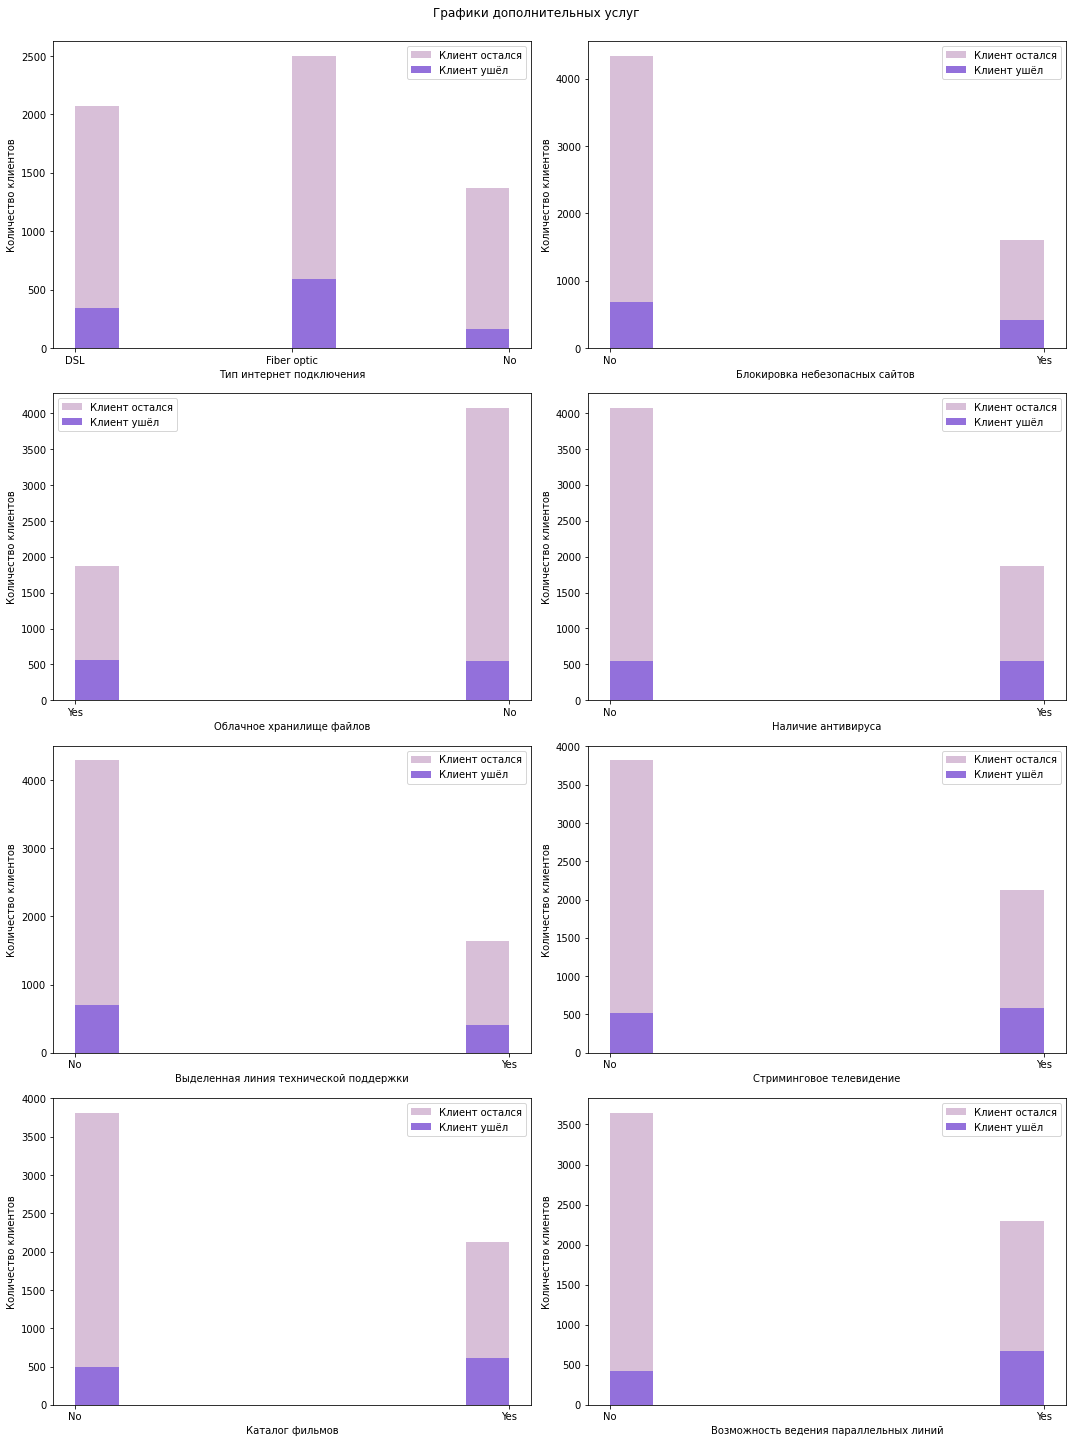

In [55]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize=[15,20])

axs[0, 0].hist(df_full.loc[df_full['target'] == 0, 'internet_service'], color='thistle')
axs[0, 0].hist(df_full.loc[df_full['target'] == 1, 'internet_service'], color='mediumpurple')

axs[0, 1].hist(df_full.loc[df_full['target'] == 0, 'online_security'], color='thistle')
axs[0, 1].hist(df_full.loc[df_full['target'] == 1, 'online_security'], color='mediumpurple')

axs[1, 0].hist(df_full.loc[df_full['target'] == 0, 'online_backup'], color='thistle')
axs[1, 0].hist(df_full.loc[df_full['target'] == 1, 'online_backup'], color='mediumpurple')

axs[1, 1].hist(df_full.loc[df_full['target'] == 0, 'device_protection'], color='thistle')
axs[1, 1].hist(df_full.loc[df_full['target'] == 1, 'device_protection'], color='mediumpurple')

axs[2, 0].hist(df_full.loc[df_full['target'] == 0, 'tech_support'], color='thistle')
axs[2, 0].hist(df_full.loc[df_full['target'] == 1, 'tech_support'], color='mediumpurple')

axs[2, 1].hist(df_full.loc[df_full['target'] == 0, 'streaming_tv'], color='thistle')
axs[2, 1].hist(df_full.loc[df_full['target'] == 1, 'streaming_tv'], color='mediumpurple')

axs[3, 0].hist(df_full.loc[df_full['target'] == 0, 'streaming_movies'], color='thistle')
axs[3, 0].hist(df_full.loc[df_full['target'] == 1, 'streaming_movies'], color='mediumpurple')

axs[3, 1].hist(df_full.loc[df_full['target'] == 0, 'multiple_lines'], color='thistle')
axs[3, 1].hist(df_full.loc[df_full['target'] == 1, 'multiple_lines'], color='mediumpurple')


axs[0, 0].set_xlabel('Тип интернет подключения')
axs[0, 0].set_ylabel('Количество клиентов')
axs[0, 0].legend(['Клиент остался', 'Клиент ушёл'])
axs[0, 1].set_xlabel('Блокировка небезопасных сайтов ')
axs[0, 1].set_ylabel('Количество клиентов')
axs[0, 1].legend(['Клиент остался', 'Клиент ушёл'])
axs[1, 0].set_xlabel('Облачное хранилище файлов')
axs[1, 0].set_ylabel('Количество клиентов')
axs[1, 0].legend(['Клиент остался', 'Клиент ушёл'])
axs[1, 1].set_xlabel('Наличие антивируса')
axs[1, 1].set_ylabel('Количество клиентов')
axs[1, 1].legend(['Клиент остался', 'Клиент ушёл'])
axs[2, 0].set_xlabel('Выделенная линия технической поддержки')
axs[2, 0].set_ylabel('Количество клиентов')
axs[2, 0].legend(['Клиент остался', 'Клиент ушёл'])
axs[2, 1].set_xlabel('Стриминговое телевидение')
axs[2, 1].set_ylabel('Количество клиентов')
axs[2, 1].legend(['Клиент остался', 'Клиент ушёл'])
axs[3, 0].set_xlabel('Каталог фильмов')
axs[3, 0].set_ylabel('Количество клиентов')
axs[3, 0].legend(['Клиент остался', 'Клиент ушёл'])
axs[3, 1].set_xlabel('Возможность ведения параллельных линий')
axs[3, 1].set_ylabel('Количество клиентов')
axs[3, 1].legend(['Клиент остался', 'Клиент ушёл'])

plt.suptitle('Графики дополнительных услуг', x=0.5, y=1)
plt.tight_layout()
plt.show()

- больше клиентов, у которых нет дополнительных услуг;
- чаще всего, для подключения, используется оптоволокно.

Исследуем баланс классов.

0    0.843675
1    0.156325
Name: target, dtype: float64


<AxesSubplot:title={'center':'Частота класса'}>

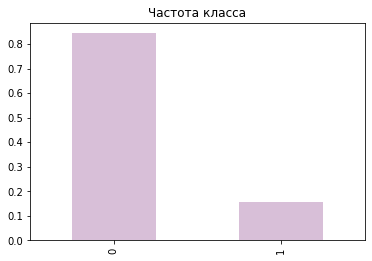

In [56]:
class_frequency = df_full['target'].value_counts(normalize=bool)
print(class_frequency)
class_frequency.plot(kind='bar', title='Частота класса', color='thistle')

В нашей задаче наблюдается сильный дисбаланс классов, что плохо сказывется на обучении модели.\
Балансировку сделаем внутри модели.

**2.8 Проверим данные на мультиколлинеарность.**

In [57]:
corr = df_full.drop(columns=['customer_id'], axis=1)

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'target', 'contract_period']


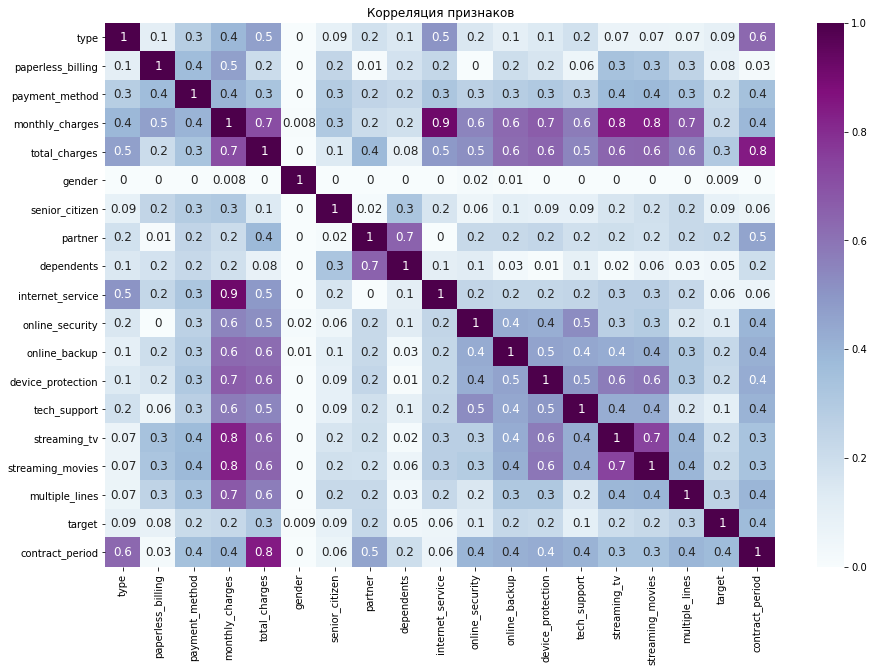

In [58]:
plt.figure(figsize=(15, 10))
plt.title('Корреляция признаков')
sns.heatmap(corr.phik_matrix(), annot = True, cmap='BuPu', annot_kws={'size':12}, fmt='.1g')
plt.show()

- отстутсвует корреляция с признаком 'gender', удалим его;
- есть высокая зависимость ежемесячных платежей от дополнительных услуг.

Удалим столбец 'gender':

In [59]:
df_full = df_full.drop(columns=['gender'], axis=1)

**Общий вывод.** 

**Проведена предобработка данных:**
- объединены таблицы по ключу customerID;
- названия столбцов приведены к змеиному стилю;
- обработаны пропущенные значения:
  - образовались пропуски в стобцах с дополнительными услугами, можем предположить:
  - если значение пропущено, то у клиента нет доп. интернет услуг и нет возможности вести параллельные линии во время звонка.
    Пропуски заменены на 'No'.
- добавлен столбец 'target' с целевым признаком;
- изменены типы данных;
- сгенерирован новый признак - срок действия договора;
- удалены лишние признаки, чтобы не было утечки в данных;

**Произведен исследовательский (графический) анализ данных. Поиск аномалий.**

**Тип оплаты.** 
- среди клиентов, которые остались, чаще всего использовалась 'ежемесячная оплата';
- для клиентов, которые ушли, тип оплаты распределён примерно одинаково.

**Ежемесячные платежи.**
- наблюдаем большой пик в районе значения суммы платежа = 20, для клиентов которые остались, скорее всего причина - в отсутствии дополнительных услуг;
- количество ушедших клиентов возрастает с увеличением суммы ежемесячного платежа;
- выбросов нет.

**Общие платежи.**
- данные распределены не нормально, пик в начале и длинный хвост вправо;
- есть выбросы, необходимо проверить:
  - большинство клиентов с общей суммой платежей более 7000 заключили контракт на 2 года;
  - исходя из столбца со сроком действия договора, срок составляет 5 лет и выше, отсюда и получаем большие платежные суммы за период.
  
**Способы оплаты.**
- самый популярный способ оплаты - электронный перевод для клиентов, которые остались;
- для клиентов, которые ушли - значения распределены примерно одинаково, кроме - почтового перевода (он самый не популярный способ оплаты).

**Пол клиентов.**
- женщин незначительно меньше для всех клиентов.

**Наличие пенсионного статуса по возрасту.**
- среди клиентов, которые ушли - доля пенсионеров выше.

**Семейное положение.** 
- осталось больше клиентов, которые не заключали брак;
- ушло больше клиентов, состоящих в браке.

**Наличие иждевенцев.**
- визуально доля клиентов, у которых есть иждевенец, одинакова и для всех клиентов.

**Срок действия договора.**
- для оставшихся клиентов видим 2 пика, короткий (возможно новые клиенты) и длинный срок действия договора;
- для ушедших клиентов - нормальное распределение;
- в среднем клиенты пользуются услугами около 3 лет, после чего постепенно начинают отказываться;

**Дополнительные услуги для клиентов.**
- больше клиентов, у которых нет дополнительных услуг;
- чаще всего, для подключения, используется оптоволокно.

**Исследован баланс классов.**
- в нашей задаче наблюдается сильный дисбаланс классов, что плохо сказывется на обучении модели.
- балансировку сделаем внутри модели.

**Проверены данные на мультиколлинеарность.**
- отстутсвует корреляция с признаком 'gender', удалим его;
- есть высокая зависимость ежемесячных платежей от дополнительных услуг.

## Подготовка данных к обучению

Признак 'customer_id' - не несет полезной информации, его отбрасываем.

Формируем фичи и целевую:

In [60]:
feature = df_full.drop(['target', 'customer_id'], axis=1)
target = df_full['target']

Разобьём на обучающую и тестовую выборки:

In [61]:
x_train, x_test, y_train, y_test = train_test_split(
    feature, target, shuffle=True, test_size=0.25, stratify=None, random_state=RANDOM_STATE)

In [62]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5282, 17), (5282,), (1761, 17), (1761,))

In [63]:
x_train.head(3)

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_period
3760,Month-to-month,Yes,Credit card (automatic),73.60,220.80,0,No,No,Fiber optic,No,No,Yes,No,No,No,No,92
3220,Two year,No,Credit card (automatic),77.30,1688.23,0,Yes,No,DSL,Yes,No,Yes,Yes,No,Yes,Yes,640
3648,One year,Yes,Electronic check,90.15,4597.65,0,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,Yes,1553


Колличественные признаки.\
Обратим внимание, что 'senior_citizen' — категориальный бинарный признак.

In [64]:
numeric_var =  x_train.select_dtypes(exclude='object').columns.to_list()
numeric_var.remove('senior_citizen')
numeric_var

['monthly_charges', 'total_charges', 'contract_period']

Категориальные признаки:

In [65]:
category_var = x_train.select_dtypes(include='object').columns.to_list()

category_var

['type',
 'paperless_billing',
 'payment_method',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

## Обучение моделей

**4.1 LogisticRegression.**

In [66]:
col_transformer_lr = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False, dtype='int'), category_var),
    (StandardScaler(), numeric_var),
      remainder='passthrough')

model_lr = LogisticRegression(random_state=RANDOM_STATE,
                             class_weight='balanced',
                             solver='liblinear')

pipline_lr = make_pipeline(col_transformer_lr, model_lr)

param_grid_lr = {
    'logisticregression__C':(0.001, 0.01, 0.1, 1, 10, 100),
    'logisticregression__penalty':('none', 'elasticnet', 'l1', 'l2')
}

In [67]:
%%time

gs_lr = RandomizedSearchCV(pipline_lr, 
                           param_grid_lr, 
                           scoring='roc_auc')

gs_lr.fit(x_train, y_train)

CPU times: user 3.53 s, sys: 1.77 s, total: 5.3 s
Wall time: 5.3 s


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='first',
                                                                                             dtype='int',
                                                                                             handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['type',
                                                                                'paperless_billing',
                                                                                'payment_method',
                                                                                'partner',
                                                                                'dependents',
                                                                                'internet_service',
                                                                                'online_security',
                                                                                'online_backup',
                                                                                'device_prote...
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['monthly_charges',
                                                                                'total_charges',
                                                                                'contract_period'])])),
                                             ('logisticregression',
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=310723,
                                                                 solver='liblinear'))]),
                   param_distributions={'logisticregression__C': (0.001, 0.01,
                                                                  0.1, 1, 10,
                                                                  100),
                                        'logisticregression__penalty': ('none',
                                                                        'elasticnet',
                                                                        'l1',
                                                                        'l2')},
                   scoring='roc_auc')

In [68]:
print(f'Лучшие параметры для логистической регрессии: ', gs_lr.best_params_)
print(f'Значение метрики AUC-ROC для лучших параметров логистической регрессии: %.4f' % gs_lr.best_score_)

Лучшие параметры для логистической регрессии:  {'logisticregression__penalty': 'l1', 'logisticregression__C': 10}
Значение метрики AUC-ROC для лучших параметров логистической регрессии: 0.7698


In [69]:
scores_lr = cross_val_score(gs_lr, 
                            x_train, 
                            y_train, 
                            cv=5, 
                            scoring='accuracy')

In [70]:
print(f'Значение метрики Accuracy для лучших параметров логистической регрессии: %.4f' % np.mean(scores_lr))


Значение метрики Accuracy для лучших параметров логистической регрессии: 0.7037


**4.2 RandomForestClassifier.**

Признак 'senior_citizen' уже бинарный, его не будем кодировать/масштабировать, добавляем remainder='passthrough', чтобы он не пропал 

In [71]:
col_transformer_rf= make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False, dtype='int'), category_var),
    (StandardScaler(), numeric_var),
     remainder='passthrough')

model_rf = RandomForestClassifier(random_state=RANDOM_STATE,
                                 class_weight='balanced')

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestclassifier__n_estimators': range(50, 251, 50),
    'randomforestclassifier__max_depth': range(2, 15),
    'randomforestclassifier__min_samples_split': (2, 3, 4),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4)
}

In [72]:
%%time

gs_rf = RandomizedSearchCV(pipline_rf, 
                           param_distributions=param_grid_rf, 
                           scoring='roc_auc',
                           n_jobs=-1, 
                           random_state=RANDOM_STATE)

gs_rf.fit(x_train, y_train)

CPU times: user 26.4 s, sys: 0 ns, total: 26.4 s
Wall time: 26.4 s


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='first',
                                                                                             dtype='int',
                                                                                             handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['type',
                                                                                'paperless_billing',
                                                                                'payment_method',
                                                                                'partner',
                                                                                'dependents',
                                                                                'internet_service',
                                                                                'online_security',
                                                                                'online_backup',
                                                                                'device_prote...
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=310723))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(2, 15),
                                        'randomforestclassifier__min_samples_leaf': (1,
                                                                                     2,
                                                                                     3,
                                                                                     4),
                                        'randomforestclassifier__min_samples_split': (2,
                                                                                      3,
                                                                                      4),
                                        'randomforestclassifier__n_estimators': range(50, 251, 50)},
                   random_state=310723, scoring='roc_auc')

In [73]:
print(f'Лучшие параметры для случайного леса: ', gs_rf.best_params_)
print(f'Значение метрики AUC-ROC для лучших параметров случайного леса: %.4f' % gs_rf.best_score_)

Лучшие параметры для случайного леса:  {'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 12}
Значение метрики AUC-ROC для лучших параметров случайного леса: 0.8180


In [74]:
scores_rf = cross_val_score(gs_rf, 
                            x_train, 
                            y_train, 
                            cv=5, 
                            scoring='accuracy')

In [75]:
print(f'Значение метрики Accuracy для лучших параметров случайного леса: %.4f' % np.mean(scores_rf))

Значение метрики Accuracy для лучших параметров случайного леса: 0.8095


**4.3 CatBoostClassifier.**

In [76]:
category_var_cb = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 
                   'internet_service', 'online_security', 'online_backup',
                   'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

In [77]:
model_cb = CatBoostClassifier(cat_features=category_var_cb,
                              random_seed=RANDOM_STATE,
                              verbose=20,
                             )

param_grid_cb = {'learning_rate': [-1, 0.01, 0.3],
                 'iterations' : [100,200,300,400,500],
                 'depth' : [2, 5, 10]}

In [78]:
%%time

grid_cb = RandomizedSearchCV(
    model_cb, 
    param_grid_cb, 
    scoring='roc_auc',
    cv=5, 
    n_jobs=1,
    random_state=RANDOM_STATE)

model_cb = grid_cb.fit(x_train, y_train)

0:	learn: 0.4795236	total: 73.5ms	remaining: 36.7s
20:	learn: 0.2228330	total: 382ms	remaining: 8.72s
40:	learn: 0.1645443	total: 745ms	remaining: 8.34s
60:	learn: 0.1148818	total: 1.22s	remaining: 8.75s
80:	learn: 0.0857449	total: 1.69s	remaining: 8.75s
100:	learn: 0.0682027	total: 2.2s	remaining: 8.68s
120:	learn: 0.0537144	total: 2.71s	remaining: 8.49s
140:	learn: 0.0444574	total: 3.23s	remaining: 8.22s
160:	learn: 0.0365356	total: 3.72s	remaining: 7.83s
180:	learn: 0.0305810	total: 4.19s	remaining: 7.38s
200:	learn: 0.0269317	total: 4.68s	remaining: 6.96s
220:	learn: 0.0230402	total: 5.14s	remaining: 6.49s
240:	learn: 0.0206349	total: 5.61s	remaining: 6.03s
260:	learn: 0.0188874	total: 6.07s	remaining: 5.56s
280:	learn: 0.0171052	total: 6.54s	remaining: 5.1s
300:	learn: 0.0158247	total: 7.02s	remaining: 4.64s
320:	learn: 0.0141578	total: 7.5s	remaining: 4.18s
340:	learn: 0.0129657	total: 7.95s	remaining: 3.71s
360:	learn: 0.0120163	total: 8.39s	remaining: 3.23s
380:	learn: 0.011393

Training has stopped (degenerate solution on iteration 6, probably too small l2-regularization, try to increase it)


0:	learn: 2.1569115	total: 9.69ms	remaining: 2.9s
20:	learn: 6279.9632909	total: 156ms	remaining: 2.07s
40:	learn: 16755.0050956	total: 239ms	remaining: 1.51s
60:	learn: 29537.5845245	total: 297ms	remaining: 1.16s
80:	learn: 38897.6597730	total: 389ms	remaining: 1.05s
100:	learn: 50329.6102384	total: 466ms	remaining: 918ms
120:	learn: 59890.6867489	total: 566ms	remaining: 838ms
140:	learn: 70716.7678342	total: 654ms	remaining: 737ms
160:	learn: 80197.3149236	total: 745ms	remaining: 643ms
180:	learn: 88552.5808962	total: 886ms	remaining: 582ms
200:	learn: 97497.9992587	total: 999ms	remaining: 492ms
220:	learn: 104999.3941159	total: 1.18s	remaining: 421ms
240:	learn: 114085.4184100	total: 1.27s	remaining: 311ms
260:	learn: 121503.8191041	total: 1.5s	remaining: 224ms
280:	learn: 129300.0945419	total: 1.62s	remaining: 110ms
299:	learn: 138390.5187413	total: 1.71s	remaining: 0us
0:	learn: 0.6867140	total: 3.91ms	remaining: 779ms
20:	learn: 0.5798579	total: 70.2ms	remaining: 599ms
40:	learn:

In [79]:
print(f'Лучшие параметры для CatBoost: ', model_cb.best_params_)
print(f'Значение метрики AUC-ROC для лучших параметров CatBoost: %.4f' % model_cb.best_score_)

Лучшие параметры для CatBoost:  {'learning_rate': 0.3, 'iterations': 500, 'depth': 10}
Значение метрики AUC-ROC для лучших параметров CatBoost: 0.8599


In [80]:
%%time
scores_cb = cross_val_score(model_cb, 
                            x_train, 
                            y_train, 
                            cv=5, 
                            scoring='accuracy')

0:	learn: 0.4756482	total: 23.4ms	remaining: 11.7s
20:	learn: 0.2010875	total: 370ms	remaining: 8.45s
40:	learn: 0.1201823	total: 793ms	remaining: 8.88s
60:	learn: 0.0864536	total: 1.24s	remaining: 8.92s
80:	learn: 0.0623976	total: 1.71s	remaining: 8.84s
100:	learn: 0.0504634	total: 2.2s	remaining: 8.68s
120:	learn: 0.0396013	total: 2.66s	remaining: 8.34s
140:	learn: 0.0331854	total: 3.12s	remaining: 7.95s
160:	learn: 0.0272122	total: 3.6s	remaining: 7.57s
180:	learn: 0.0230675	total: 4.07s	remaining: 7.17s
200:	learn: 0.0195634	total: 4.59s	remaining: 6.83s
220:	learn: 0.0171292	total: 5.06s	remaining: 6.39s
240:	learn: 0.0151043	total: 5.54s	remaining: 5.95s
260:	learn: 0.0134536	total: 6.04s	remaining: 5.53s
280:	learn: 0.0119002	total: 6.57s	remaining: 5.12s
300:	learn: 0.0109057	total: 7.01s	remaining: 4.63s
320:	learn: 0.0099011	total: 7.48s	remaining: 4.17s
340:	learn: 0.0091909	total: 7.99s	remaining: 3.73s
360:	learn: 0.0085899	total: 8.47s	remaining: 3.26s
380:	learn: 0.00803

Training has stopped (degenerate solution on iteration 6, probably too small l2-regularization, try to increase it)


0:	learn: 2.2791445	total: 24.5ms	remaining: 7.32s
20:	learn: 7415.6592748	total: 121ms	remaining: 1.61s
40:	learn: 14148.6825490	total: 248ms	remaining: 1.57s
60:	learn: 25345.5330421	total: 328ms	remaining: 1.28s
80:	learn: 33701.3776180	total: 377ms	remaining: 1.02s
100:	learn: 42575.8326476	total: 487ms	remaining: 959ms
120:	learn: 52752.1367896	total: 549ms	remaining: 812ms
140:	learn: 61972.4074010	total: 623ms	remaining: 703ms
160:	learn: 70270.7730815	total: 689ms	remaining: 595ms
180:	learn: 81548.9545411	total: 785ms	remaining: 516ms
200:	learn: 91344.1935943	total: 851ms	remaining: 419ms
220:	learn: 99662.8993143	total: 953ms	remaining: 341ms
240:	learn: 108376.6379730	total: 1.04s	remaining: 254ms
260:	learn: 119438.1079928	total: 1.12s	remaining: 167ms
280:	learn: 127665.1361979	total: 1.22s	remaining: 82.4ms
299:	learn: 134948.2914247	total: 1.31s	remaining: 0us
0:	learn: 2.2228952	total: 25.4ms	remaining: 7.59s
20:	learn: 7020.6370916	total: 187ms	remaining: 2.48s
40:	le

Training has stopped (degenerate solution on iteration 7, probably too small l2-regularization, try to increase it)


0:	learn: 2.2927595	total: 23.4ms	remaining: 6.99s
20:	learn: 6794.5290564	total: 141ms	remaining: 1.88s
40:	learn: 10649.5898060	total: 271ms	remaining: 1.71s
60:	learn: 13417.0051906	total: 409ms	remaining: 1.6s
80:	learn: 15874.4363543	total: 552ms	remaining: 1.49s
100:	learn: 18666.1775772	total: 696ms	remaining: 1.37s
120:	learn: 21684.6641649	total: 775ms	remaining: 1.15s
140:	learn: 24874.6440466	total: 884ms	remaining: 996ms
160:	learn: 27476.9673207	total: 1.01s	remaining: 875ms
180:	learn: 30254.8604174	total: 1.16s	remaining: 762ms
200:	learn: 33336.6844805	total: 1.28s	remaining: 629ms
220:	learn: 36044.4464134	total: 1.4s	remaining: 502ms
240:	learn: 38269.1401018	total: 1.54s	remaining: 377ms
260:	learn: 41240.0355653	total: 1.69s	remaining: 252ms
280:	learn: 44675.2464134	total: 1.8s	remaining: 122ms
299:	learn: 47239.6963148	total: 1.95s	remaining: 0us
0:	learn: 2.2069815	total: 23.8ms	remaining: 7.1s
20:	learn: 7021.2343782	total: 237ms	remaining: 3.15s
40:	learn: 1031

In [81]:
print(f'Значение метрики Accuracy для лучших параметров CatBoost: %.4f' % np.mean(scores_cb))

Значение метрики Accuracy для лучших параметров CatBoost: 0.8739


Проанализируем, сравним результаты, выберем лучшую модель и проверим её качество на тестовой выборке.

In [82]:
results = {
    'Model' : ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'],
    'AUC-ROC' :pd.Series([gs_lr.best_score_, gs_rf.best_score_, model_cb.best_score_]),
    'Accuracy' :pd.Series([np.mean(scores_lr), 
                           np.mean(scores_rf), 
                           np.mean(scores_cb)])
    }
display(pd.DataFrame(results))

,Model,AUC-ROC,Accuracy
0,LogisticRegression,0.769789,0.703714
1,RandomForestClassifier,0.817952,0.809543
2,CatBoostClassifier,0.859935,0.873913


Вывод:

Лучший результат у модели CatBoostClassifier:

параметры для CatBoostClassifier:  {'learning_rate': 0.3, 'iterations': 500, 'depth': 10} \
значение метрики AUC-ROC для лучших параметров CatBoostClassifier : 0.8599 \
её и будем проверять на тестовой выборке.

**Посмотрим важность признаков:**

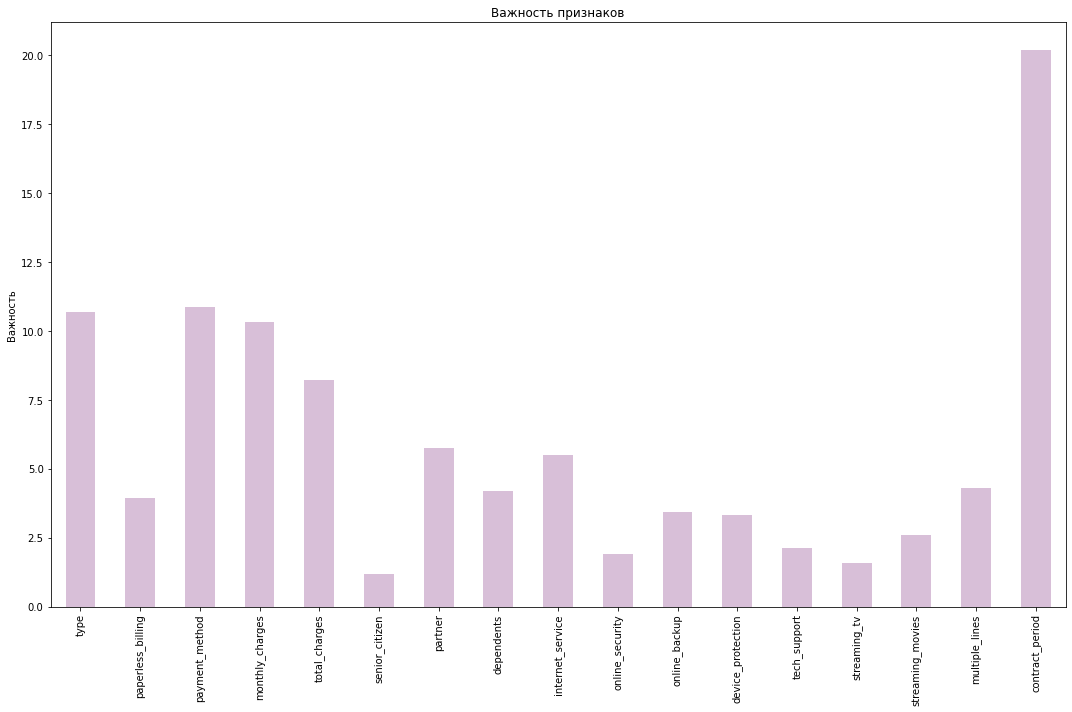

In [83]:
imp = pd.Series(model_cb.best_estimator_.feature_importances_,
               x_train.columns)

fig, ax = plt.subplots(figsize=(15,10))
imp.plot.bar(ax=ax, color='thistle')
ax.set_title('Важность признаков')
ax.set_ylabel('Важность')
fig.tight_layout()



Наибольшее влияние на отток клиентов оказывают:

- срок действия договора;
- сумма ежемесячного платежа;
- тип оплаты.

## Тестирование модели

Лучший результат у модели CatBoostClassifier:

In [84]:
test_predictions = model_cb.predict(x_test)

probabilities_valid_test = model_cb.predict_proba(x_test)
probabilities_one_valid_test = probabilities_valid_test[:, 1]

print(f'Значение метрики AUC-ROC на тестовой выборке для лучших параметров CatBoost: %.4f' %  
      roc_auc_score(y_test, probabilities_one_valid_test))
print(f'Значение метрики Accuracy на тестовой выборке для лучших параметров CatBoost: %.4f' % 
      accuracy_score(y_test, model_cb.predict(x_test)))

Значение метрики AUC-ROC на тестовой выборке для лучших параметров CatBoost: 0.8692
Значение метрики Accuracy на тестовой выборке для лучших параметров CatBoost: 0.8813


Значение метрики AUC-ROC на тестовой выборке: 0.8692 - что соответствует условию AUC-ROC >= 0.85.

**Построим ROC-кривую:**

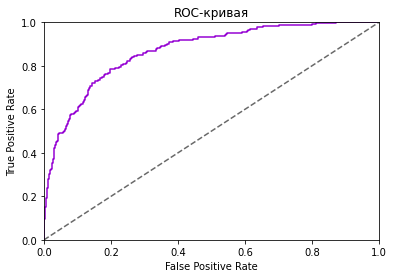

In [85]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid_test)

plt.figure()
plt.plot(fpr, tpr, color='darkviolet')
plt.plot([0, 1], [0, 1], linestyle='--', color='dimgrey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**Общий вывод:**
1. **Были подготовлены данные:**
- в таблице "Информация о договорах" - 7043 строк и 8 столбцов;
- из 7043 клиентов - 5942 договор не расторгали.
- в таблице "Персональные данные клиента" 7043 строк и 5 столбцов;
- в таблице "Информация об интернет-услугах" 5517 строк и 8 столбцов;
- в таблице "Информация об услугах телефонии" 6361 строка и 2 столбцов;

2. **Проведена предобработка данных:**
- объединены таблицы по ключу customerID;
- названия столбцов приведены к змеиному стилю;
- обработаны пропущенные значения:
  - образовались пропуски в стобцах с дополнительными услугами, можем предположить:
  - если значение пропущено, то у клиента нет доп. интернет услуг и нет возможности вести параллельные линии во время звонка.
    Пропуски заменены на 'No'.
- добавлен столбец 'target' с целевым признаком;
- изменены типы данных;
- сгенерирован новый признак - срок действия договора;
- удалены лишние признаки, чтобы не было утечки в данных;

**Произведен исследовательский (графический) анализ данных. Поиск аномалий.**

**Тип оплаты.** 
- среди клиентов, которые остались, чаще всего использовалась 'ежемесячная оплата';
- для клиентов, которые ушли, тип оплаты распределён примерно одинаково.

**Ежемесячные платежи.**
- наблюдаем большой пик в районе значения суммы платежа = 20, для клиентов которые остались, скорее всего причина - в отсутствии дополнительных услуг;
- количество ушедших клиентов возрастает с увеличением суммы ежемесячного платежа;
- выбросов нет.

**Общие платежи.**
- данные распределены не нормально, пик в начале и длинный хвост вправо;
- есть выбросы, необходимо проверить:
  - большинство клиентов с общей суммой платежей более 7000 заключили контракт на 2 года;
  - исходя из столбца со сроком действия договора, срок составляет 5 лет и выше, отсюда и получаем большие платежные суммы за период.
  
**Способы оплаты.**
- самый популярный способ оплаты - электронный перевод для клиентов, которые остались;
- для клиентов, которые ушли - значения распределены примерно одинаково, кроме - почтового перевода (он самый не популярный способ оплаты).

**Пол клиентов.**
- женщин незначительно меньше для всех клиентов.

**Наличие пенсионного статуса по возрасту.**
- среди клиентов, которые ушли - доля пенсионеров выше.

**Семейное положение.** 
- осталось больше клиентов, которые не заключали брак;
- ушло больше клиентов, состоящих в браке.

**Наличие иждевенцев.**
- визуально доля клиентов, у которых есть иждевенец, одинакова и для всех клиентов.

**Срок действия договора.**
- для оставшихся клиентов видим 2 пика, короткий (возможно новые клиенты) и длинный срок действия договора;
- для ушедших клиентов - нормальное распределение;
- в среднем клиенты пользуются услугами около 3 лет, после чего постепенно начинают отказываться;

**Дополнительные услуги для клиентов.**
- больше клиентов, у которых нет дополнительных услуг;
- чаще всего, для подключения, используется оптоволокно.

**Исследован баланс классов.**
- в нашей задаче наблюдается сильный дисбаланс классов, что плохо сказывется на обучении модели.
- балансировку сделаем внутри модели.

**Проверены данные на мультиколлинеарность.**
- отстутсвует корреляция с признаком 'gender', удалим его;
- есть высокая зависимость ежемесячных платежей от дополнительных услуг.

3. **Подготовлены данные и обучены модели:**

| Model | AUC-ROC | Accuracy | 
|---|---|-----------|
| LogisticRegression | 0.769789 | 0.703714 | 
| RandomForestClassifier | 	0.817952 | 0.809543 | 
| CatBoostClassifier | 0.859935 | 0.873913 | 

параметры для CatBoostClassifier:  {'learning_rate': 0.3, 'iterations': 500, 'depth': 10} \
значение метрики AUC-ROC для лучших параметров CatBoostClassifier : **0.8599** \
её и будем проверять на тестовой выборке.

Наибольшее влияние на отток клиентов оказывают:

- срок действия договора;
- сумма ежемесячного платежа;
- тип оплаты.

4. **Произведена проверка на тестовой выборке:**
- значение метрики AUC-ROC на тестовой выборке для лучших параметров CatBoost: **0.8692** - что соответствует условию AUC-ROC >= 0.85.
- значение метрики Accuracy на тестовой выборке для лучших параметров CatBoost: **0.8813**

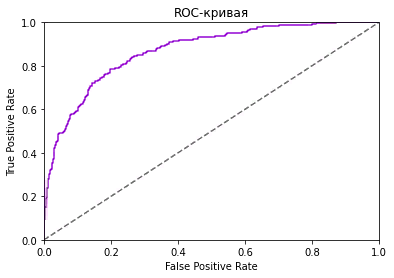

## Отчет по работе

Целью работы было:
- построить модель, которая будет прогнозировать отток клиентов оператора связи.

Критерием оценки: 
- значение основной метрики AUC-ROC >= 0.85.

Предварительно был составлен план работы, все пункты были выполнены.\
Также добавлены новые пункты, а именно:
- проверка на дисбаланс классов (после проверки возникла необходимость балансировки);
- балансировка класса (произведена внутри модели);
- исследование важности признаков (чтобы увидеть как признаки влияют на отток клиентов);
- построение ROC-кривой (чтобы оценить качество работы классификатора).

Необходимость в данных пунктах возникла сама собой по мере выполнения работы.

В плане было прописано обучение модели LGBM, а фактически была обучена - CatBoostClassifier, т.к. скорость обучения у данной модели выше.

Затруднение вызвали пропущенные значения в столбце 'total_charges', которые не отображались как пропуски и были обнаружены при попытке поменять тип данных столбца. Пропуски были принудительно заменены на NaN и в последствии обработаны, а именно:
- заполнены суммой ежемесячных платежей, т.к. клиенты новые и по ним еще нет данных об общей сумме всех платежей.

Также в соответствии с планом была произведена предобработка данных, а именно:
- объединены таблицы по ключу customerID;
- названия столбцов приведены к змеиному стилю;
- обработаны пропущенные значения:
  - образовались пропуски в стобцах с дополнительными услугами:
  - если значение пропущено, то у клиента нет доп. интернет услуг и нет возможности вести параллельные линии во время звонка.
    Пропуски заменены на 'No'.
- изменены типы данных;
- произведен исследовательский (графический) анализ данных;
- выялены аномалии:
  - большинство клиентов с общей суммой платежей более 7000 заключили контракт на 2 года;
  - исходя из столбца со сроком действия договора, срок составляет 5 лет и выше, отсюда и получили большие платежные суммы за период.

Для обучения моделей были сгенерированы новые признаки:
- 'target' с целевым признаком - где 0-клиент остался, 1 - клиент ушёл;
- 'contract_period' - со сроком действия договора.

Удалены признаки:
- 'end_date' и 'begin_date', чтобы не было утечки данных;
- 'gender' - из-за нулевой зависимости с другими признаками;
- 'customer_id' - т.к. он не несёт полезной информации для обучения модели.

В итоге для обучения были использованы следующие признаки.

Числовые:
- 'monthly_charges',
- 'total_charges',
- 'contract_period'

Категориальные:
- type',
- 'paperless_billing',
- 'payment_method',
- 'partner', 
- 'dependents', 
- 'internet_service', 
- 'online_security', 
- 'online_backup',
- 'device_protection',  
- 'tech_support', 
- 'streaming_tv', 
- 'streaming_movies', 
- 'multiple_lines',  
- 'senior_citizen' (категориальный бинарный признак).

Также, для обучения данные были:
- разделены на выборки: обучающая (75%) и тестовая (25%);
- масштабированы;
- закодированы категориальные признаки техникой OHE;

Были обучены 3 модели:

| Model | AUC-ROC | Accuracy | 
|---|---|-----------|
| LogisticRegression | 0.769789 | 0.703714 | 
| RandomForestClassifier | 	0.817952 | 0.809543 | 
| CatBoostClassifier | 0.859935 | 0.873913 | 

**Лучший результат получили у модели CatBoostClassifier:**

- **параметры для CatBoostClassifier: {'learning_rate': 0.3, 'iterations': 500, 'depth': 10}**
- **значение метрики AUC-ROC для лучших параметров CatBoostClassifier : 0.8599**
- **значение метрики AUC-ROC на тестовой выборке для лучших параметров CatBoostClassifier: 0.8692, \
что соответствует критерию AUC-ROC >= 0.85.**

Все этапы работы важны, каждый из них дает возможность лучше разобраться в данных, чтобы достичь максимально высокого результата.

Размер тестовой выборки:\
test_size = 0.25\
Параметр RANDOM_STATE = 310723.